# How to recover from errors in Tools

## Step-1

Pass the error we got from our tool back to chatGPT

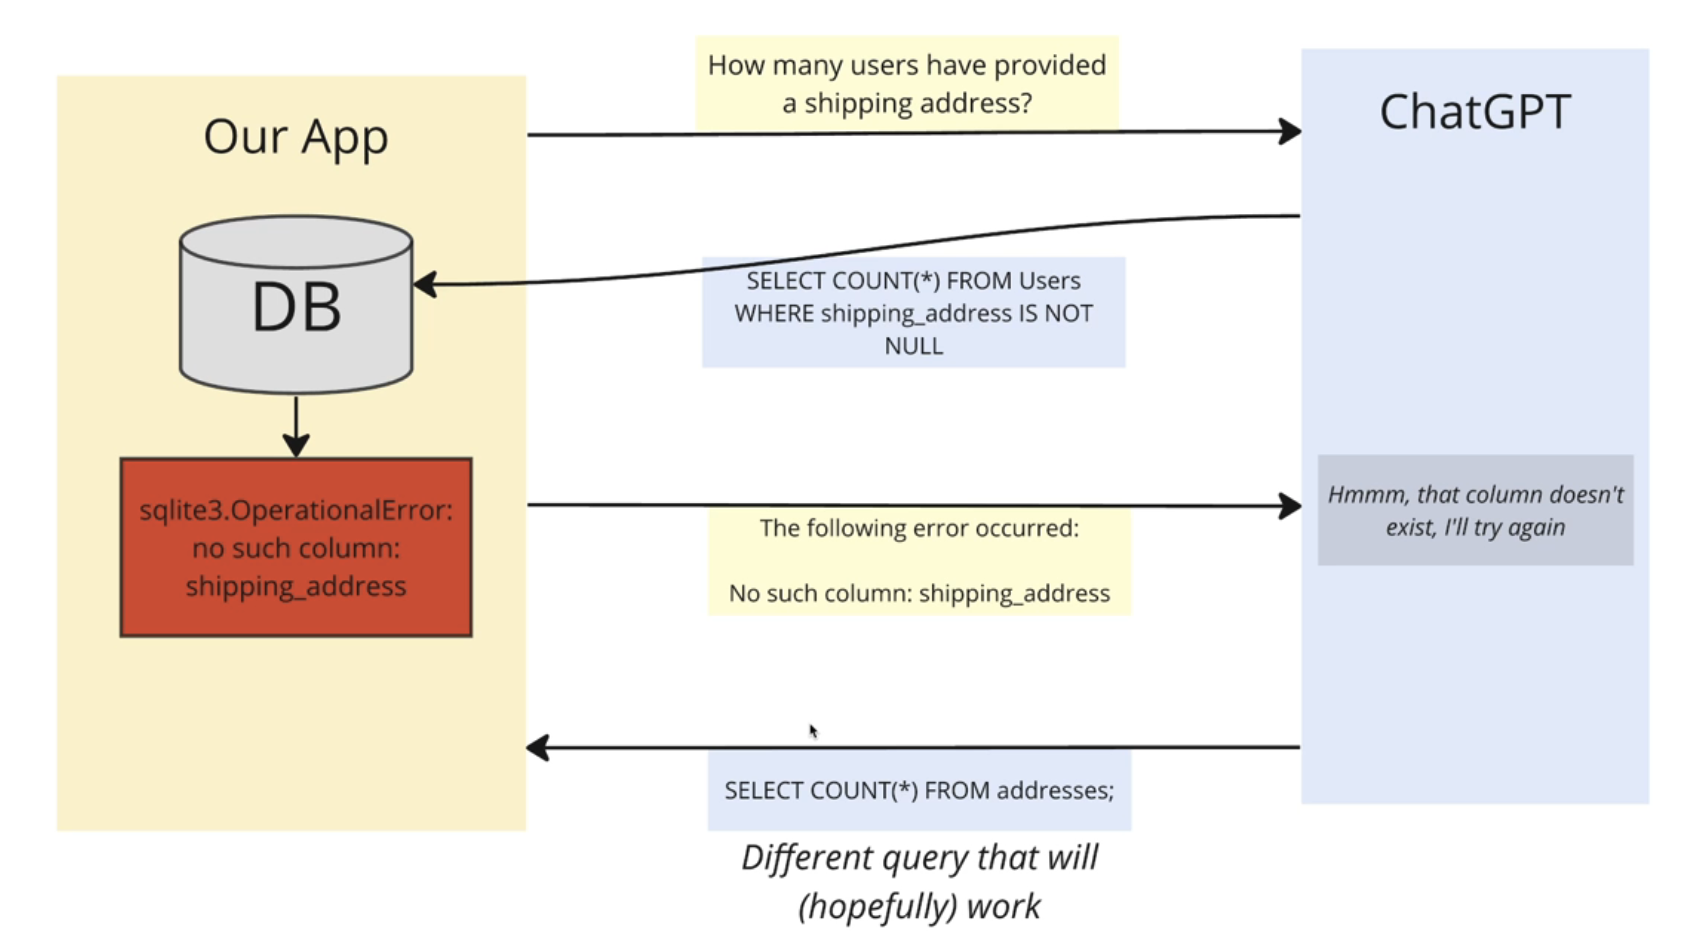

We add the try and except block like below to acheive step-1

```python
# Define a function that is actually going to be executed whenver ChatGPT decided that it needs to execute a query.
def run_sqlite_query(query):
    # This returns an object which gives us access to the database
    c = conn.cursor()
    try:
        # Execute the query
        c.execute(query)

        # We are collecting all the information for all the different rows that get returned, and we are sending
        # it back to ChatGPT by returning it from this funciton.
        return c.fetchall()
    except sqlite3.OperationalError as err:
        # The below return will directly be send back to ChatGPT
        return f"The following error occured: {str(err)}"
```

## Step-2: Adding Table context

* We will add `system message` and a new Tool called `describe_tables` along with HumanMessage

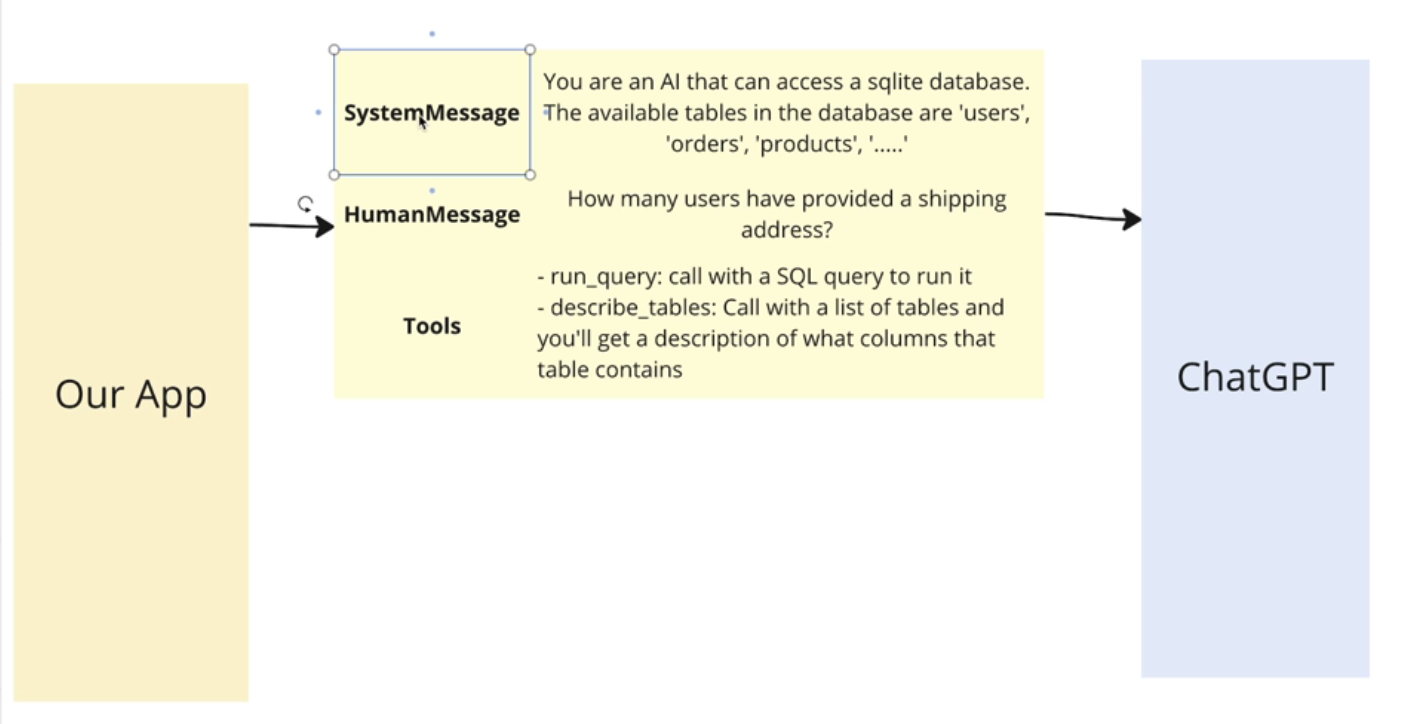

### a. adding a system-message 

1. Pass the list of `tables` in the SystemMessage for chatgpt to better understand what tables are involved
2. Be direct with system messages like below telling chatGpt to not make any assumptions and to use the tools given.

```python
prompt = ChatPromptTemplate(
    messages=[
        # Use this `SystemMessage` schema when there is no `input_variables` or `templating` is needed. Use this when we are hardcoding a string.
        SystemMessage(
            content=(
                "You are an AI that has access to a SQLite database."
                f"The database has tables of: {tables} \n"
                "Do not make any assumptions about what tables exist "
                "or what columsn exist. Instead, use the 'describe_tables' function"
            )
        ),
        HumanMessagePromptTemplate.from_template(
            "{input}"
        ),  # human-input will be coming in `input` variable
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ],
)
```

### b. adding a table description tool

```python
# Define a function that is actually going to be executed whenver ChatGPT decided that it needs to get table schema.
def describe_tables(table_names):
    c = conn.cursor()

    tables = ", ".join(
        "'" + table + "'" for table in table_names
    )  # Output-structure: "'users', 'orders', 'products'"

    # Gives us back list of tuples  amd then first element inside the tuple is going to be the structure or schema of the chosen table
    rows = c.execute(
        f"SELECT sql FROM sqlite_master WHERE type='table' and name IN ({tables});"
    )

    # print the table structure in a readable way to send to the prompt and then to LLM
    return "\n".join(row[0] for row in rows if row[0] is not None)

# Setup Tool: Tool is going to take the configutation given and then Serialize to a `function object` to send in the Prompt
describe_tables_tool = Tool.from_function(
    name="describe_tables",  # tool name
    description="Given a list of table names, returns the schema of those tables",  # this description is used by ChatGPT on when to run the tool.
    func=describe_tables, # Pass a function that needs to be executed whenever ChatGpt decides to run a function.
)
```

## Step-3: Adding better description for tool arguments

By default,The below is what langchain sends to chatGPT in the function. It sends `__arg1` as the argument to chatGPT.

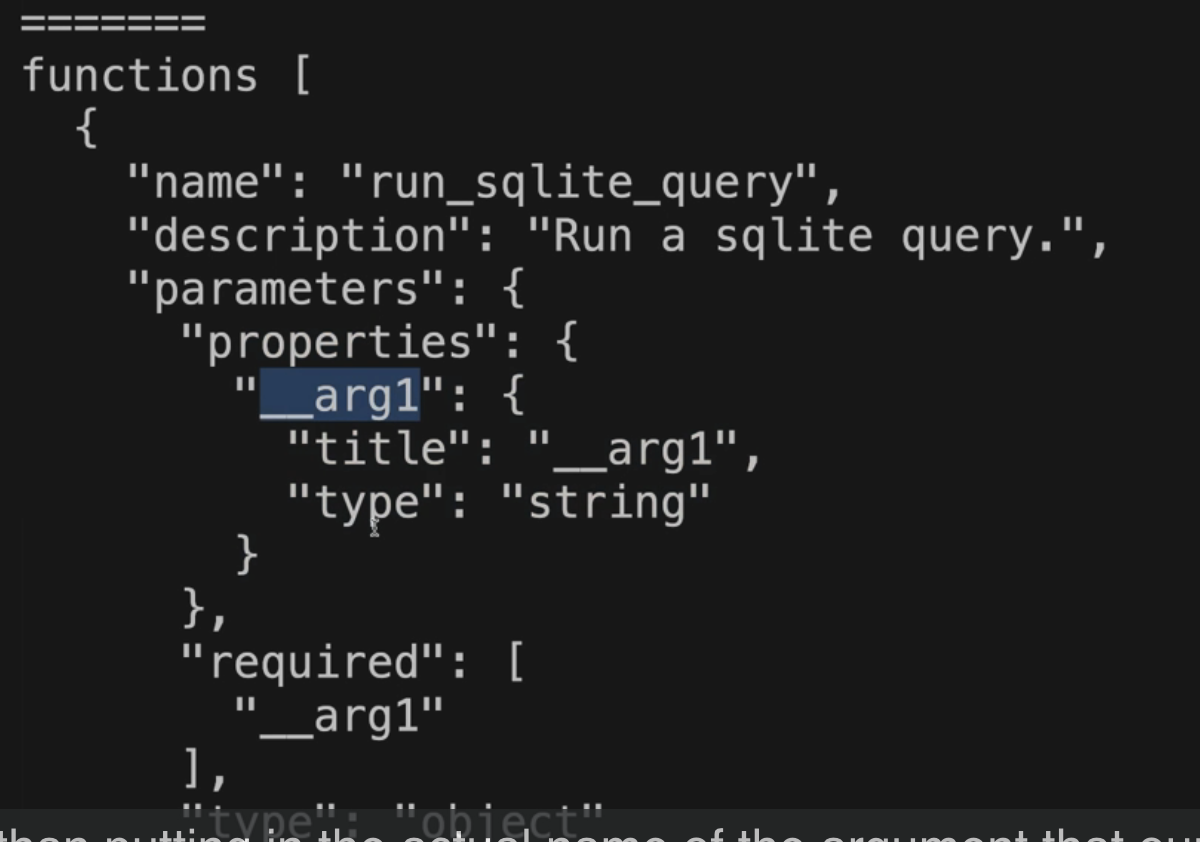

We can tell what to be passed and what to get back from chatGPT like below:

```python
# Lanchain internally uses this information `query` as `str` to better describe the different arguments that
# ChatGPt or LLM should be providing to our tool.
# In other words, we are telling LLM or chatGPT to use our tool, you need to provide the below argument
class RunQueryArgsSchema(BaseModel):
    query: str


# Setup Tool: Tool is going to take the configutation given and then Serialize to a `function object` to send in the Prompt
run_query_tool = Tool.from_function(
    name="run_sqlite_query",  # tool name
    description="Run a sqlite query.",  # this description is used by ChatGPT on when to run the tool.
    func=run_sqlite_query,  # Pass a function that needs to be executed whenever ChatGpt decides to run a function.
    args_schema=RunQueryArgsSchema,  # Lanchain internally uses
)
```

Then we will be sending like below:

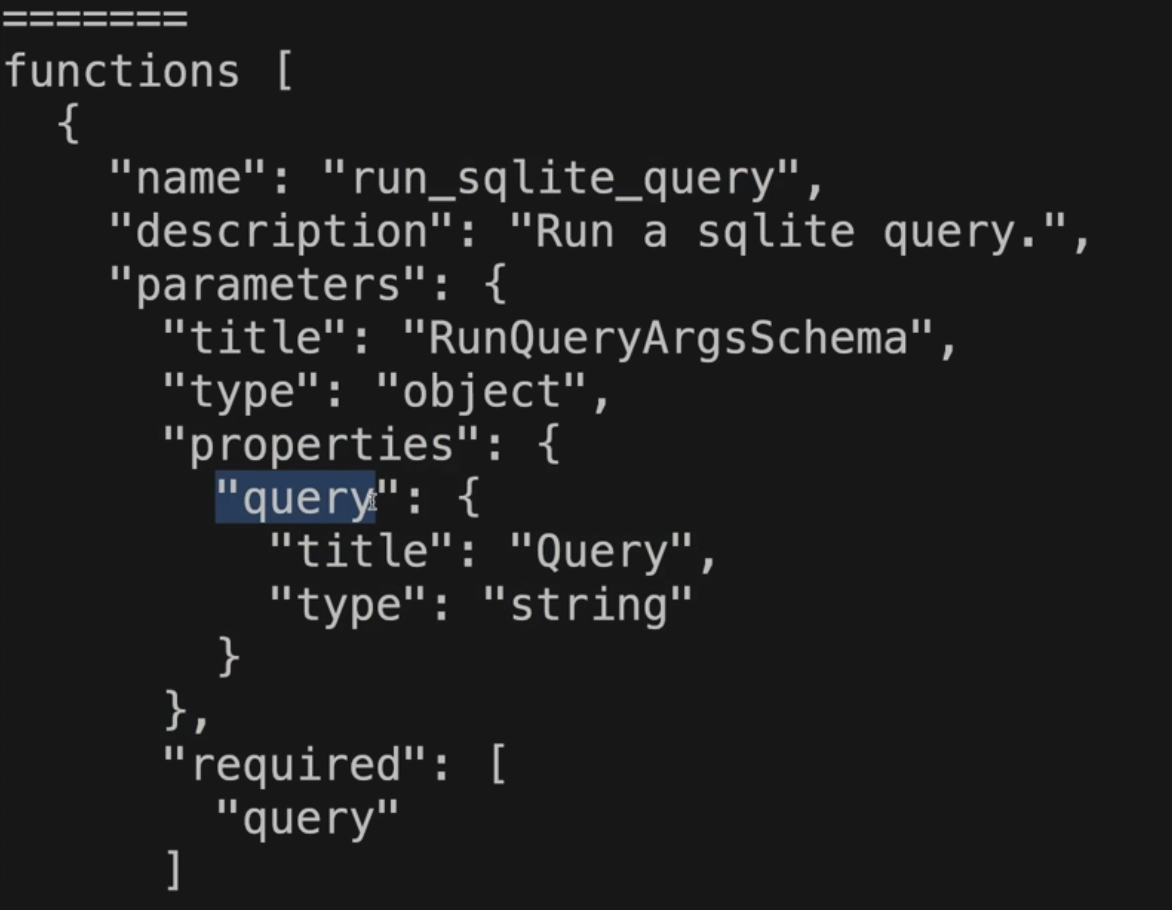
